# **1. Load and normalize dataset(MNIST)**

In [64]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [65]:
batch_size_train = 100
batch_size_test = 500

mnist_trainset =  datasets.MNIST('./data', train=True, download=True,
                             transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

mnist_testset =  datasets.MNIST('./data', train=False, download=True,
                             transform=transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape


torch.Size([500, 1, 28, 28])

 optionally visualize data to further understand the output from dataloader

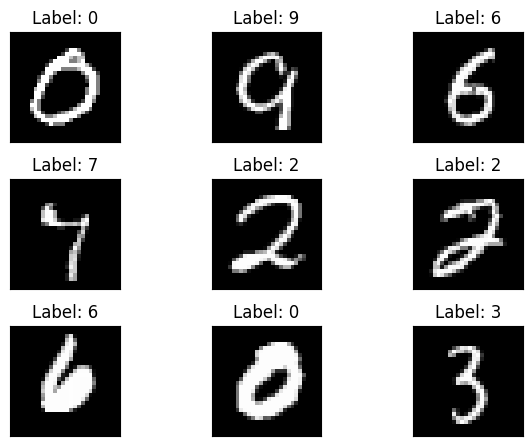

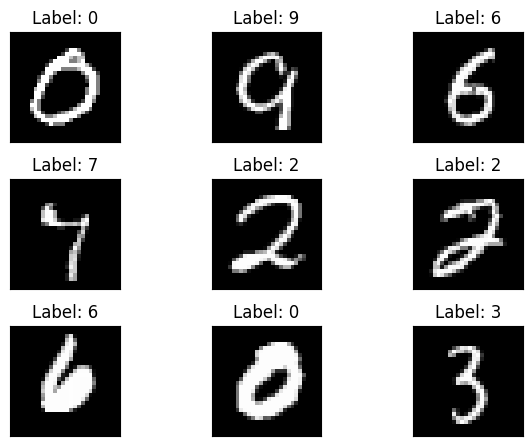

In [66]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig


data normalization:28x28-> 32x32

In [67]:
trans = transforms.Compose([
    # To resize image
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    # To normalize image
    transforms.Normalize((0.5,), (0.5,))
])

mnist_trainset = torchvision.datasets.MNIST(
root = './data',
train = True,
download = True,
transform = trans
)

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

mnist_testset = torchvision.datasets.MNIST(
root = './data',
train = True,
download = True,
transform = trans
)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size_test, shuffle=True)

img, label = mnist_trainset[0]
img.shape, label


(torch.Size([1, 32, 32]), 5)

Label:  5


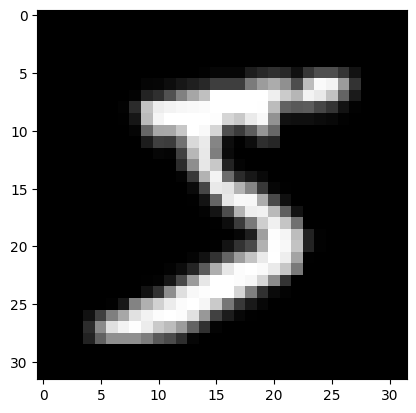

In [68]:
def show_img(img, label):
    print('Label: ', label)
    plt.imshow(img.permute(1,2,0), cmap = 'gray')

show_img(*mnist_trainset[0])

# **2.Define a LeNet-5**

2.1 LeNet-5:5 layers,3 convolutional layer,2 fully connect layer

In [69]:
import torch.nn as nn
import torch.nn.functional as F



class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


net = LeNet5()
print(net)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [70]:
sample = next(iter(mnist_trainset))
img = sample[0]
img.shape

torch.Size([1, 32, 32])

# **3. Define a Loss function and optimizer**
Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [71]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# **4.Train the LeNet-5**

In [72]:

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 0:    # print every 600 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.005
[1,   501] loss: 1.876
[2,     1] loss: 0.002
[2,   501] loss: 0.617
[3,     1] loss: 0.001
[3,   501] loss: 0.353
[4,     1] loss: 0.000
[4,   501] loss: 0.260
[5,     1] loss: 0.000
[5,   501] loss: 0.209
[6,     1] loss: 0.000
[6,   501] loss: 0.176
[7,     1] loss: 0.000
[7,   501] loss: 0.151
[8,     1] loss: 0.001
[8,   501] loss: 0.132
[9,     1] loss: 0.000
[9,   501] loss: 0.118
[10,     1] loss: 0.000
[10,   501] loss: 0.110
Finished Training


# **5.Test the MLP with testset**

In [73]:

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 97 %


# **6. Print out the performance using PyTorch Profiler**

In [74]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

execution time analysis:

In [81]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        net(inputs)

In [82]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         8.79%       1.534ms       100.00%      17.457ms      17.457ms             1                                                                                []  
                 aten::max_pool2d         0.10%      17.000us        25.46%       4.444ms       4.444ms             1                                            [[100, 6, 28, 28], [], [], [], 

memory consumption analysis:

In [83]:
with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    net(inputs)
print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       aten::tanh        15.02%       2.326ms        15.02%       2.326ms     581.500us       2.48 Mb       2.48 Mb             4  
                      aten::empty         0.30%      47.000us         0.30%      47.000us      11.750us       2.40 Mb       2.40 Mb             4  
    aten::max_pool2d_with_indices        30.03%       4.652ms        30.03%       4.652ms       2.326ms       1.80 Mb       1.80 Mb             2  
                      aten::addmm         3.25%     504.000us         3.78%     585.000us     195.000us      83.

In [84]:
print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       aten::tanh        15.02%       2.326ms        15.02%       2.326ms     581.500us       2.48 Mb       2.48 Mb             4  
                     aten::conv2d         0.14%      22.000us        50.36%       7.800ms       3.900ms       2.40 Mb           0 b             2  
                aten::convolution         0.50%      77.000us        50.22%       7.778ms       3.889ms       2.40 Mb           0 b             2  
               aten::_convolution         0.25%      38.000us        49.72%       7.701ms       3.850ms       2.